<a href="https://colab.research.google.com/github/broker-workshop/tutorials/blob/main/Pitt-Google/Pitt-Google-Tutorial-Code-Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker Tutorial: Code Samples

| | Learning Objective | Section | Notes |
|---|---|---|---|
| 1. | Understand What, Where, How to access | 1) Introduction | ZTF data. Google Cloud SDK (Python, command-line). `pgb-utils` Python package. |
| 2. | Access the data | 3) BigQuery Database | Alert data (no cutouts), lightcurves, cone search. Standard SQL queries (Python, command-line). `pgb-utils` helper functions. |
| | | 4) Files in Cloud Storage | Alert packets in Avro file format (includes cutouts). Direct downloads. |
| 3. | Process the data | 5) Apache Beam data pipelines |  End-to-end, working examples with templates for user-defined functions. |

---
This "Code Samples" notebook is a condensed version of the full [Pitt-Google-Tutorial.ipynb](https://colab.research.google.com/github/broker-workshop/tutorials/blob/main/Pitt-Google/Pitt-Google-Tutorial.ipynb), which you can refer to for further information. 

---

# 1) Introduction

## 1a) Data overview

See full tutorial.

## 1b) `pgb_utils` overview

See full tutorial.

## 1c) Note on costs

Everything we do in this tutorial falls well within Google's [Free Tier](https://cloud.google.com/free). See full tutorial for more information.

---

# 2) Setup

1. Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to create a GCP project. 
It is a simple process, and you do not need to enable billing of any kind. Take note of the auto-generated "Project ID", you will need it below in order to make API calls.

2. Installs, imports, etc.:

In [1]:
pgb_project_name = 'pitt-google-broker-prototype'
pgb_project_id = 'ardent-cycling-243415'

In [2]:
# ENTER YOUR GCP PROJECT ID HERE
my_project_id = 

In [3]:
!{'pip install pgb-utils'}

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 6.3MB 12.3MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 215kB 48.3MB/s 
     |████████████████████████████████| 9.0MB 53.2MB/s 
     |████████████████████████████████| 174kB 41.2MB/s 
     |████████████████████████████████| 1.3MB 41.6MB/s 
     |████████████████████████████████| 1.1MB 47.7MB/s 
     |████████████████████████████████| 378kB 46.2MB/s 
     |████████████████████████████████| 2.2MB 44.4MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 17.7MB 249kB/s 
     |████████████████████████████████| 153kB 39.0MB/s 
     |████████████████████████████████| 829kB 38.8MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 112kB 33.4MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-cp37-

In [4]:
import apache_beam as beam
import aplpy
from astropy import coordinates as coord
from astropy import units as u
from astropy.io import fits
import fastavro
from google.colab import auth, drive
import gzip
import io
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path

from google.cloud import bigquery, storage

import pgb_utils as pgb

In [5]:
auth.authenticate_user()
# follow the instructions to authorize Google Cloud SDK 

In [6]:
# For demonstration of command-line tools, create a fnc for running shell commands
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [7]:
# Connect your Google Drive file system
# to be used in the sections on File Storage and Apache Beam pipelines
drive.mount('/content/drive') 
# follow the instructions to authorize access

# create a path for later
colabpath = '/content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial'
colabpath_noesc = '/content/drive/MyDrive/Colab Notebooks/PGB_tutorial'
run(f'mkdir -p {colabpath}')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

# Colab Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive
>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial



---

# 3) BigQuery Database

## 3a) Python

### Table names and schemas

In [8]:
# Create a Client for the BigQuery connections below
pgb.bigquery.create_client(my_project_id)
# this is just a convenience wrapper, as are many pgb functions. look at
# its source code for guidance on using `google.cloud` libraries directly.

# Colab Hint: Mouse over the function name to see its definition and
#             source code (make sure the cell is selected).


Instantiating a BigQuery client with project_id: ardent-cycling-243415



In [9]:
pgb.bigquery.get_dataset_table_names()

Getting table names for dataset: ztf_alerts


['salt2', 'alerts', 'DIASource']

In [10]:
pgb.bigquery.get_table_info('DIASource')

# Colab Hint: Right-click this cell and select "Copy to scratch cell"
#             so you can use this as a reference in later queries.

ardent-cycling-243415.ztf_alerts.DIASource
+-----+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|     | column_name            | description                                                                                                                                                                                                                  | type    |
+=====+========================+==============================================================================================================================================================================================================================+=========+
|   0 | schemavsn              | schema version used                                                                                                           

---

### Query lightcurves and other history

In [11]:
# Choose the history data you want returned
columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'DIASource' table
# pgb.bigquery.get_table_info('DIASource')

In [12]:
# Choose specific objects (optional. we'll choose some to minimize load time)
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

# you can also restrict sample size using the `limit` keyword below

To retrieve lightcurves and other history, we must query for objects' "DIASource" observations and aggregate the results by `objectId`.

`pgb.bigquery.query_objects()` is a convenience wrapper that let's you grab all the results at once, or step through them using a generator.
It's options are demonstrated below.

In [13]:
# Option 1: Get a single DataFrame of all results

lcs_df = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we'll skip this using
dry_run = False

lcs_df.sample(10)
# cleaned of duplicates


Query statement:

"SELECT objectId, ARRAY_AGG(candid ORDER BY candidate.jd) AS candid, ARRAY_AGG(candidate.jd ORDER BY candidate.jd) AS jd, ARRAY_AGG(candidate.magpsf ORDER BY candidate.jd) AS magpsf, ARRAY_AGG(candidate.sigmapsf ORDER BY candidate.jd) AS sigmapsf, ARRAY_AGG(candidate.fid ORDER BY candidate.jd) AS fid FROM `ardent-cycling-243415.ztf_alerts.alerts` WHERE objectId IN ("ZTF18aczuwfe","ZTF18aczvqcr","ZTF20acqgklx","ZTF18acexdlh") GROUP BY objectId"

will process 1586466594 bytes of data.
(0.144% of your 1 TiB Free Tier monthly allotment.)
Continue? [y/N]: y


jd     magpsf  sigmapsf  fid
objectId     candid                                                     
ZTF18aczuwfe 1469258283415015005  2.459224e+06  20.287066  0.212321    2
ZTF20acqgklx 1467211215215015018  2.459222e+06  18.819756  0.094562    2
ZTF18acexdlh 1446436925615015006  2.459201e+06  19.379440  0.175275    1
             1538147615615015006  2.459293e+06  19.659389  0.165467    1
ZTF18aczuwfe 1479213073415015001  2.459234e+06  19.893818  0.178393    2
ZTF18aczvqcr 1444284213615015013  2.459199e+06  19.540318  0.158637    2
             1554175053615015021  2.459309e+06  19.666422  0.166205    2
ZTF20acqgklx 1414351235215015023  2.459169e+06  19.898302  0.171336    2
ZTF18aczuwfe 1499283323415015000  2.459254e+06  19.891897  0.193669    2
ZTF18acexdlh 1508273721415015040  2.459263e+06  19.474018  0.132851    1

Congratulations! You've now retrieved your first data from the transient table. 
It is a DataFrame containing the candidate observations for every object we requested, indexed by `objectId` and `candid` (candidate ID). It includes the columns we requested in the query.

Queries can return large datasets. You may want to use a generator to step through objects individually, and avoid loading the entire dataset into memory at once.
`query_objects()` can return one for you:

In [14]:
# Option 2: Get a generator that yields a DataFrame for each objectId

iterator = True
objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=iterator,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates

for lc_df in objects:
    print(f'\nobjectId: {lc_df.objectId}')  # objectId in metadata
    print(lc_df.sample(5))


objectId: ZTF18acexdlh
                               jd     magpsf  sigmapsf  fid
candid                                                     
1508274200315015010  2.459263e+06  19.312220  0.162628    1
1536203621415015012  2.459291e+06  19.716902  0.142650    1
1444421735615010004  2.459199e+06  18.782455  0.085394    2
1540149315615010004  2.459295e+06  19.623976  0.184744    1
1470275475615015007  2.459225e+06  19.228634  0.139192    2

objectId: ZTF18aczuwfe
                               jd     magpsf  sigmapsf  fid
candid                                                     
1497147413415015000  2.459252e+06  19.797361  0.184142    1
1501265423415015001  2.459256e+06  20.191540  0.173003    2
1510206363415015002  2.459265e+06  19.803467  0.164810    1
1477168703415015002  2.459232e+06  19.468252  0.211510    2
1444285643415015001  2.459199e+06  19.927372  0.209740    2

objectId: ZTF18aczvqcr
                               jd     magpsf  sigmapsf  fid
candid                      

Each DataFrame contains data on a single object, and is indexed by `candid`. The `objectId` is in the metadata.

`query_objects()` can also return a json formatted strings of the query results, or the raw `query_job` object that is returned by the Google Cloud SDK. See the full tutorial for details.

---

#### Plot a lightcurve

In [15]:
# Get an object's lightcurve DataFrame with the minimum required columns
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lc_df = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

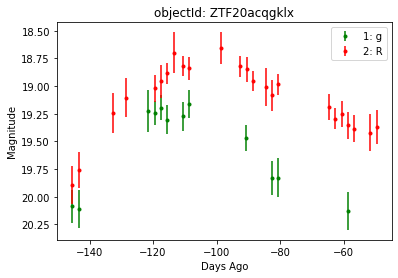

In [16]:
# make the plot
pgb.figures.plot_lightcurve(lc_df, objectId=objectId)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

### Cone Search

See full tutorial.

---

### Direct access: Google Cloud SDK

See full tutorial.

---

## 3b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

In [17]:
# Get help
run('bq help query')

>> bq help query
Python script for interacting with BigQuery.


USAGE: bq.py [--global_flags] <command> [--command_flags] [args]


query                      Execute a query.

                           Query should be specified on command line, or passed
                           on stdin.

                           Examples:
                           bq query 'select count(*) from
                           publicdata:samples.shakespeare'
                           echo 'select count(*) from
                           publicdata:samples.shakespeare' | bq query

                           Usage:
                           query [<sql_query>]

                           Flags for query:

                             /tools/google-cloud-sdk/platform/bq/bq.py:
                               --[no]allow_large_results: Enables larger
                                 destination table sizes for legacy SQL queries.
                               --[no]append_table: When a destination tabl

In [18]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.DIASource')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

>> bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.DIASource

Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
[
  {
    "#": 1, 
    "friendlyName": "Budget", 
    "projectId": "budget-242622"
  }, 
  {
    "#": 2, 
    "friendlyName": "Kafka to BigQuery", 
    "projectId": "kafka-to-bigquery"
  }, 
  {
    "#": 3, 
    "friendlyName": "My First Project", 
    "projectId": "smiling-timing-239918"
  }, 
  {
    "#": 4, 
    "friendlyName": "Pitt-Broker", 
    "projectId": "pitt-broker"
  }, 
  {
    "#": 5, 
    "friendlyName": "pitt-google-broker-prototype", 
    "projectId": "ardent-cycling-243415"
  }
]
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a

In [19]:
# Query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)

>> bq query --use_legacy_sql=false 'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'

Waiting on bqjob_r57c25a995ef910f8_00000178b81fcb0d_1 ... (0s) Current status: DONE   
+--------------+---------------------+--------------------+-----------------------+---------------------+----------------------+--------------------+------+
|   objectId   |       candid        |         t0         |          x0           |         x1          |          c           |       chisq        | ndof |
+--------------+---------------------+--------------------+-----------------------+---------------------+----------------------+--------------------+------+
| ZTF18acedtrr | 1442360400815015020 |  59176.99998225879 | 1.3255153910836994E-4 |   4.168200374483106 |    1.245159555305304 |  6.582997838131519 |    4 |
| ZTF18acwgwjx | 1442358985215015026 |  59157.00084732172 |  2.749450331673211E-4 |    3.06

---

# 4) Files in Cloud Storage

## 4a) Python

See full tutorial.

### Download files

### Plot cutouts and lightcurves

## 4b) Command-line tool `gsutil`

See full tutorial.

---

# 5) Apache Beam data pipelines

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines. The [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) is very useful! 

In this "Code Samples" notebook, we demonstrate working examples that retrieve and process ZTF data and write out the results. The full tutorial has much more information on basic concepts and some of the many available options.

---

## 5a) A demo example

See full tutorial.

---

## 5b) Descriptions

See full tutorial.

---

## 5c) Pitt-Google working examples

In these examples, we will query the database for object histories (lightcurves) and cast them to DataFrames, apply a filter and a processing function, and write the results to a text file.

Note that Beam _overloads_ some operators:
- `|` means `apply`
- `>>` allows you to name the step with the preceeding string. It is optional. We use it here to improve readability. Various UIs like Dataflow use it in their displays.

Here's a preview of the pipeline we will create and run.

Pipeline:

```python
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read from BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Type cast to DataFrame' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        | 'Is nearby known SS object' >> beam.Filter(nearby_ssobject)
        | 'Calculate mean magnitudes' >> beam.ParDo(calc_mean_mags())
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )
```

With comments:

```python
# 0. Instantiate a pipeline object
with beam.Pipeline() as pipeline:
    (

# 1. Start the pipeline by piping it to a "read" function. Then format the incoming data as a DataFrame.
        pipeline
        | 'Read from BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Type cast to DataFrame' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        
# 2. PROCESS the data with USER-DEFINED FUNCTIONS
        # Apply a Filter
        | 'Is nearby known SS object' >> beam.Filter(nearby_ssobject)
        # Apply a processing function
        | 'Calculate mean magnitudes' >> beam.ParDo(calc_mean_mags())
        
# 3. Output the results
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )
```

First, let's define our user-defined functions: a filter and a processing function.
Both will take as input `lc_df`, a single object's lightcurve (or history) DataFrame.
_The functions will work as-is, or you can use them as templates to create your own._

_Colab Hint_: Right-click on one of the code cells with a function definition and select "Copy to scratch cell". Use the new scratch cell to change the function and experiment with the pipeline.

In [20]:
# Filter for likely solar system objects

def nearby_ssobject(lc_df):
    """Keep only objects that are within 5" of a known solar system object.
    To be called with `beam.Filter(nearby_ssobject)`.
    """

    ssdistnr = lc_df['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)

    return ssobject_is_near
    # generally: return a bool where `True` means we keep this df, else drop it

In [21]:
# Processing: Calculate and return the mean magnitude per passband

class calc_mean_mags(beam.DoFn):
    """Class that wraps our `process()` function to calculate mean magnitudes.
    To be called with `beam.ParDo(calc_mean_mags())`.
    """

    def process(self, lc_df):
        """Calculate mean magnitudes per passband."""

        meanmags = lc_df[['fid','magpsf']].groupby('fid').mean()

        # we will write this to a file, so let's format it nicely
        output = []
        for fid, row in meanmags.iterrows():
            output.append(f"{lc_df.objectId},{fid},{row['magpsf']}")

        return output
        # generally: return a list containing 0 or more elements, each of which
        # becomes an element in the `ParDo`'s output collection.

Now let's configure and run specific pipelines.

### Lightcurve pipeline

Set configs

See the "BigQuery Database" section for options to generate the query statement, or write your own SQL.

Use `pgb.bigquery.get_table_info('DIASource')` in a scratch cell to view options for column names.


In [22]:
# keyword args for `ReadFromBigQuery()`
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000  # just to reduce runtime
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str
read_args = {
    'query': query, 
    'project': my_project_id,  
    'use_standard_sql': True, 
    'gcs_location': f'gs://{pgb_project_id}-workshop_beam_test',
    # courtesy location for temp files, available for the workshop duration
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/meanmags'

Define and run the pipeline

In [23]:
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        | 'Extract lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        | 'Nearby SS object' >> beam.Filter(nearby_ssobject)
        | 'Calc mean mags' >> beam.ParDo(calc_mean_mags())
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


Congratulations! You just ran an Apache Beam pipeline that fetches ZTF data, filters and processes it, and writes out the results!

Let's look at the first 10 results. Remember, there are no ordering guarantees.

In [24]:
run('head -n 10 {}-00000-of-*'.format(outputs_prefix))

>> head -n 10 /content/drive/MyDrive/Colab\ Notebooks/PGB_tutorial/outputs/meanmags-00000-of-*
ZTF20acpndcj,1,19.738000869750977
ZTF20acpmovb,1,19.95023536682129
ZTF20acpmpey,1,19.37099266052246
ZTF20acpkjny,1,17.65648651123047
ZTF20acpjwyj,1,19.88270378112793
ZTF20acpmypw,1,20.50773334503174
ZTF20acpkzyi,2,20.21710968017578
ZTF20acpjrwq,2,19.619338989257812
ZTF20acpldmu,2,19.378652572631836
ZTF20acplytn,2,17.22441864013672



### Cone Search pipeline

See full tutorial.